## Set up the dependencies

In [0]:
!pip install pydicom
!pip install lime
!pip install PIL

In [0]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
cd './drive/My Drive/MLHC Project Resources/python_code/'

In [0]:
from load_model import *
from utils import *

## Run LIME on input

In [0]:
#@markdown Load model, define `transformer`
model = load_model()

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

=> loading checkpoint
=> loaded checkpoint


In [0]:
#@markdown Define `batch_image_predict`
def batch_image_predict(images):
    """
    Args:
        img_batch: list of 3-dimensional numpy array
    
    Global Variables:
        model: pre-trained model supplied by Alexandru
        transformer: pre-processing instance
    """
    pred_list = []

    for img in images:
      #convert np array to PIL.Image
      img_PIL = Image.fromarray(img).convert('RGB')

      #transform
      input_var = transformer(img_PIL)

      #predict, take the average of the predictions and save as np array
      output = model(input_var)
      output_mean = output.mean(0).detach().cpu().numpy()

      #store
      pred_list.append(output_mean)
    
    numpy_probs = np.stack(pred_list, axis=0)
    return numpy_probs

In [0]:
#@markdown Define `explain_instance`
def explain_instance(img, img_diseases = None, num_samples = 5, print_image = True):
    """
    Args:
        img: the original 3-dimensional numpy array before transforming into torch tensor
        img_diseases: string of diseases for the image
        num_samples: 5 (the number of neighbours to consider)
    
    Global Variables:
        explainer: pre-defined explainer object
    """
    explanation = explainer.explain_instance(img,
                                             batch_image_predict,
                                             top_labels=5, 
                                             num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)

    img_boundry2 = mark_boundaries(temp, mask)
    if print_image:
      plt.imshow(img_boundry2)

    if img_diseases is not None:
        plt.title(f"Diseases: {img_diseases}")
        
    return mask

In [0]:
files = os.listdir('./files/chex-ray-14')
img_ids = ['./files/chex-ray-14/' + file for file in files if '.png' in file]

img = Image.open(img_ids[0]).convert('RGB')
img_np = np.array(img)

In [0]:
img_ids[0]

'./files/chex-ray-14/00014075_003.png'

In [0]:
img_np.shape

(1024, 1024, 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

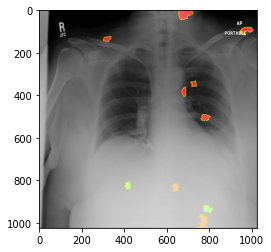

In [0]:
explainer = lime_image.LimeImageExplainer()
explain_instance(img_np, num_samples = 10)

## Find neighbours of the input in the CheX-ray-14 dataset from VAE

In [0]:
cd '/content/'

/content


In [0]:
# specify global vars
DATA_DIR = './drive/My Drive/MLHC Project Resources/python_code/files/chex-ray-14'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

# check what files we actually have on our google drive
files = os.listdir(DATA_DIR)
img_ids = [file for file in files if '.png' in file]
print(f"Number of Images on Google Drive: {len(img_ids)}")

Device = cuda
Number of Images on Google Drive: 10015


In [0]:
#@markdown Define `ChestXrayDataSet` class
class ChestXrayDataSet(Dataset):
    def __init__(self, data_dir, list_of_image_list_file, subset_img_ids, transform=None):
        """
        Args:
            data_dir: path to image directory.
            list_of_image_list_file:  list of paths to the file containing images
                with corresponding labels.
            subset_img_ids: a subset of images that we actually have
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        for image_list_file in list_of_image_list_file:
          with open(image_list_file, "r") as f:
              for line in f:
                  items = line.split()
                  image_name= items[0]
                  if image_name in subset_img_ids:
                      label = items[1:]
                      label = [int(i) for i in label]
                      image_name = os.path.join(data_dir, image_name)
                      image_names.append(image_name)
                      labels.append(label)

        self.image_names = image_names
        self.labels = labels
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                 transforms.Resize((224,224)),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

In [0]:
DIM = 224
LATENT_DIM = 60
test_dataset = ChestXrayDataSet(data_dir = DATA_DIR,
                            list_of_image_list_file = [DATA_DIR + '/train_list.txt',
                                               DATA_DIR + '/val_list.txt',
                                               DATA_DIR + '/test_list.txt'],
                            subset_img_ids = img_ids, 
                            transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                            transforms.Resize((DIM,DIM)),
                                                            transforms.ToTensor()]))

In [0]:
#@markdown Define `VAE` class and `load_VAE_model` function
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(DIM * DIM, 500)
        self.fc21 = nn.Linear(500, LATENT_DIM)
        self.fc22 = nn.Linear(500, LATENT_DIM)
        self.fc3 = nn.Linear(LATENT_DIM, 500)
        self.fc4 = nn.Linear(500, DIM * DIM)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, DIM*DIM))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, DIM*DIM), reduction='sum')

#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD

def load_VAE_model(model_save_name):
  path = F"./drive/My Drive/MLHC Project Resources/python_code/vae_models/{model_save_name}.pt" 
  model = VAE()
  model.load_state_dict(torch.load(path))
  print(f"Model successfully loaded from {path}")
  model.to(device)
  return model

In [0]:
print(device)

cuda


In [0]:
model_VAE = load_VAE_model("10k_vae60_dim224_epoch25_batch64_A-12_09-May-2020 (18:54:22.919440)")

In [0]:
#@markdown Define `get_latent_representations_and_labels` and get a tensor of all latent vectors in `latent_representation_tensor`
def get_latent_representations_and_labels(test_dataset, idx, model):
  images, labels = test_dataset[idx]
  mu,logvar = model.encode(images.to(device).view(-1, DIM*DIM))
  latent_representations = model.reparameterize(mu, logvar)
  return latent_representations.squeeze(), labels

N_EXAMPLES = 10000
N_LABELS = 14
latent_representation_tensor = torch.zeros((N_EXAMPLES,LATENT_DIM))
labels_tensor = torch.zeros((N_EXAMPLES,N_LABELS))
for i in tqdm(range(N_EXAMPLES)):
  latent_representation_tensor[i,:], labels_tensor[i,:] = get_latent_representations_and_labels(test_dataset,i,model_VAE)

In [0]:
latent_representation_tensor.shape

torch.Size([100, 60])

In [0]:
np.savetxt('./drive/My Drive/MLHC Project Resources/python_code/vae_models/latent_representations.csv', latent_representation_tensor.detach().numpy(), delimiter=',')

In [0]:
#import latent_representations.csv
# latent_representation_array = np.genfromtxt('./drive/My Drive/MLHC Project Resources/python_code/vae_models/latent_representations.csv', delimiter=',')

In [0]:
#@markdown Define `compute_labels` and `compute_nearest_neighbours` functions
def compute_labels(index, labels_tensor):
  CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
  N_LABELS = len(CLASS_NAMES)
  if sum(labels_tensor[index,:]) == 0:
    return ["None"]
  else:
    return([CLASS_NAMES[i] for i in range(N_LABELS) if labels_tensor[index,i] == 1])

def compute_nearest_neighbours(latent_representation_tensor, only_neighbours = False):
  distance_matrix = pairwise_distances(latent_representation_tensor.detach().numpy())
  np.fill_diagonal(distance_matrix, np.inf)
  nearest_neighbours = np.argsort(distance_matrix, axis = 1)[:,:5]
  NN_dict = {}
  for i in range(nearest_neighbours.shape[0]):
    neighbours_of_i = nearest_neighbours[i,:]
    if only_neighbours:
      NN_dict[i] = neighbours_of_i.tolist()
    else:
      NN_dict[i] = { n:compute_labels(n,labels_tensor) for n in neighbours_of_i} 
      NN_dict[i]["Condition"] = compute_labels(i, labels_tensor)
  return(NN_dict)

In [0]:
NN_dict = compute_nearest_neighbours(latent_representation_tensor, only_neighbours = True)

In [0]:
i = 93
NN_dict[i]

[1866, 9027, 9194, 3225, 711]

## Run LIME on each neighbour, saving the mask

In [0]:
cd './drive/My Drive/MLHC Project Resources/python_code/'

In [0]:
files = os.listdir('./files/chex-ray-14')
img_paths = ['./files/chex-ray-14/' + file for file in files if '.png' in file]

input_id = 93
neighbour_ids = NN_dict[i]
mask_total = np.zeros((1024, 1024))

In [0]:
for neighbour_id in tqdm(neighbour_ids):
  img = Image.open(img_paths[neighbour_id]).convert('RGB')
  img_np = np.array(img)

  explainer = lime_image.LimeImageExplainer()
  mask = explain_instance(img_np, num_samples = 1000, print_image=False)
  mask_total += mask

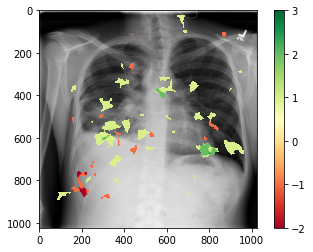

In [0]:
img = Image.open(img_paths[input_id]).convert('RGB')
img_np = np.array(img)

mask_total[mask_total == 0.0] = np.nan  #s.t. zeros become transparent

plt.imshow(img_np)
plt.imshow(mask_total, cmap=plt.get_cmap('RdYlGn'))
plt.colorbar()
plt.show()